/opt/anaconda3/envs/smg/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


최적 임계값: 0.4299999999999998
=== Confusion Matrix (Test) ===
[[1416   14]
 [  41  153]]

=== Classification Report (Test) ===
              precision    recall  f1-score   support

           0     0.9719    0.9902    0.9809      1430
           1     0.9162    0.7887    0.8476       194

    accuracy                         0.9661      1624
   macro avg     0.9440    0.8894    0.9143      1624
weighted avg     0.9652    0.9661    0.9650      1624



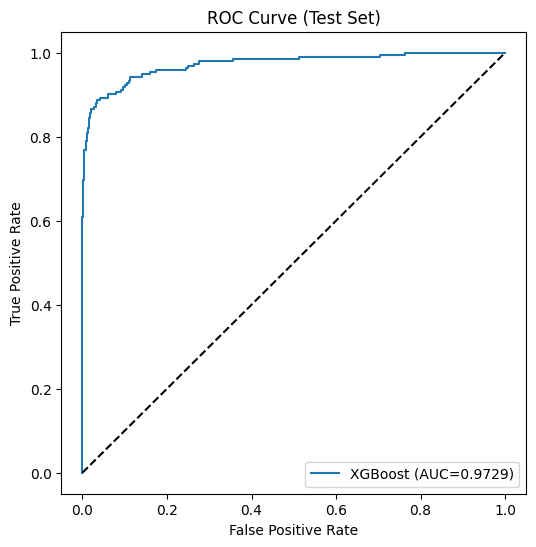

/var/folders/ss/8b0r3m9j5gs5sf13x_633qfh0000gp/T/ipykernel_93447/57932425.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=feat_importance, palette="viridis")


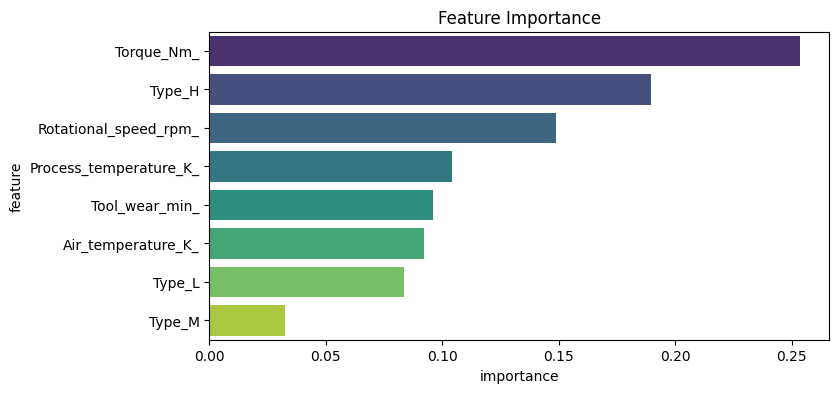

모델 저장 완료: ../models/xgb_final_model.pkl


In [1]:
# 1. 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from xgboost import XGBClassifier

# 2. 데이터 불러오기
X_train = pd.read_csv("../data/X_train.csv")
X_val   = pd.read_csv("../data/X_val.csv")
X_test  = pd.read_csv("../data/X_test.csv")

# 컬럼명 벨류에러로 특수문자 제거
for df in [X_train, X_val, X_test]:
    df.columns = df.columns.str.replace(r"[^A-Za-z0-9_]+", "_", regex=True)

y_train = pd.read_csv("../data/y_train.csv").iloc[:, 0].values.ravel()
y_val   = pd.read_csv("../data/y_val.csv").iloc[:, 0].values.ravel()
y_test  = pd.read_csv("../data/y_test.csv").iloc[:, 0].values.ravel()

# 3. XGBoost 학습
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)
xgb.fit(X_train, y_train)

# 4. 최적 임계값 적용 (Validation set에서 F1 기준)
val_proba = xgb.predict_proba(X_val)[:, 1]
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = []

from sklearn.metrics import f1_score
for thr in thresholds:
    preds = (val_proba >= thr).astype(int)
    f1_scores.append(f1_score(y_val, preds))

best_thr = thresholds[np.argmax(f1_scores)]
print("최적 임계값:", best_thr)

# 5. Test set 평가
test_proba = xgb.predict_proba(X_test)[:, 1]
y_pred_test = (test_proba >= best_thr).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
print("=== Confusion Matrix (Test) ===")
print(cm)

# Classification Report
print("\n=== Classification Report (Test) ===")
print(classification_report(y_test, y_pred_test, digits=4))

# 6. ROC Curve
fpr, tpr, _ = roc_curve(y_test, test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"XGBoost (AUC={roc_auc:.4f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.legend()
plt.show()

# 7. Feature Importance 시각화
feat_importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": xgb.feature_importances_
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(x="importance", y="feature", data=feat_importance, palette="viridis")
plt.title("Feature Importance")
plt.show()

# 8. 모델 저장
import joblib
joblib.dump(xgb, "../models/xgb_final_model.pkl")
print("모델 저장 완료: ../models/xgb_final_model.pkl")

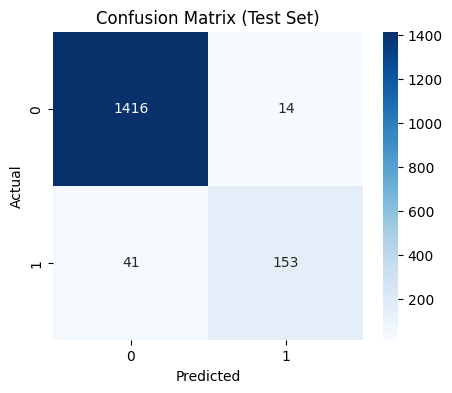

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test Set)")
plt.show()